# Data preparation

In this notebook we're going to analyze and modify the dataset we found in order to make it suitable for the Bayesian Network implementation in pgmpy.

- [Patterns/Cleaning](#show-data-patterns-and-cleaning)
- [Binning and encoding](#binning-and-encoding)
- [Final result](#final-result)

## Show data patterns and cleaning

In [84]:
import pandas as pd

df = pd.read_csv("./datasets/dataset_raw.csv").drop(labels=["id"], axis=1)
print(f"Shape: {df.shape}")
# df.head()

Shape: (27901, 17)


In [85]:
df.info()
print(f"Duplicates: {sum(df.duplicated())}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 17 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Gender                                 27901 non-null  object 
 1   Age                                    27901 non-null  float64
 2   City                                   27901 non-null  object 
 3   Profession                             27901 non-null  object 
 4   Academic Pressure                      27901 non-null  float64
 5   Work Pressure                          27901 non-null  float64
 6   CGPA                                   27901 non-null  float64
 7   Study Satisfaction                     27901 non-null  float64
 8   Job Satisfaction                       27901 non-null  float64
 9   Sleep Duration                         27901 non-null  object 
 10  Dietary Habits                         27901 non-null  object 
 11  De

As we can see many dtypes are not discrete (float64) as required from Bayesian Networks and we can see also many non numerical attributes (object). We'll have to make some bins and some encodings in order to overcome the problem.

Moreover we can notice that the data itself has some null values in the "Financial Stress" attribute, we'll drop those samples.

In [86]:
df_notna = df.dropna()
print(f"Dropped {df.shape[0] - df_notna.shape[0]} rows with nulls")

Dropped 3 rows with nulls


Then we'll plot the data in order to see some useful patterns which could also help us improving the dataset quality.

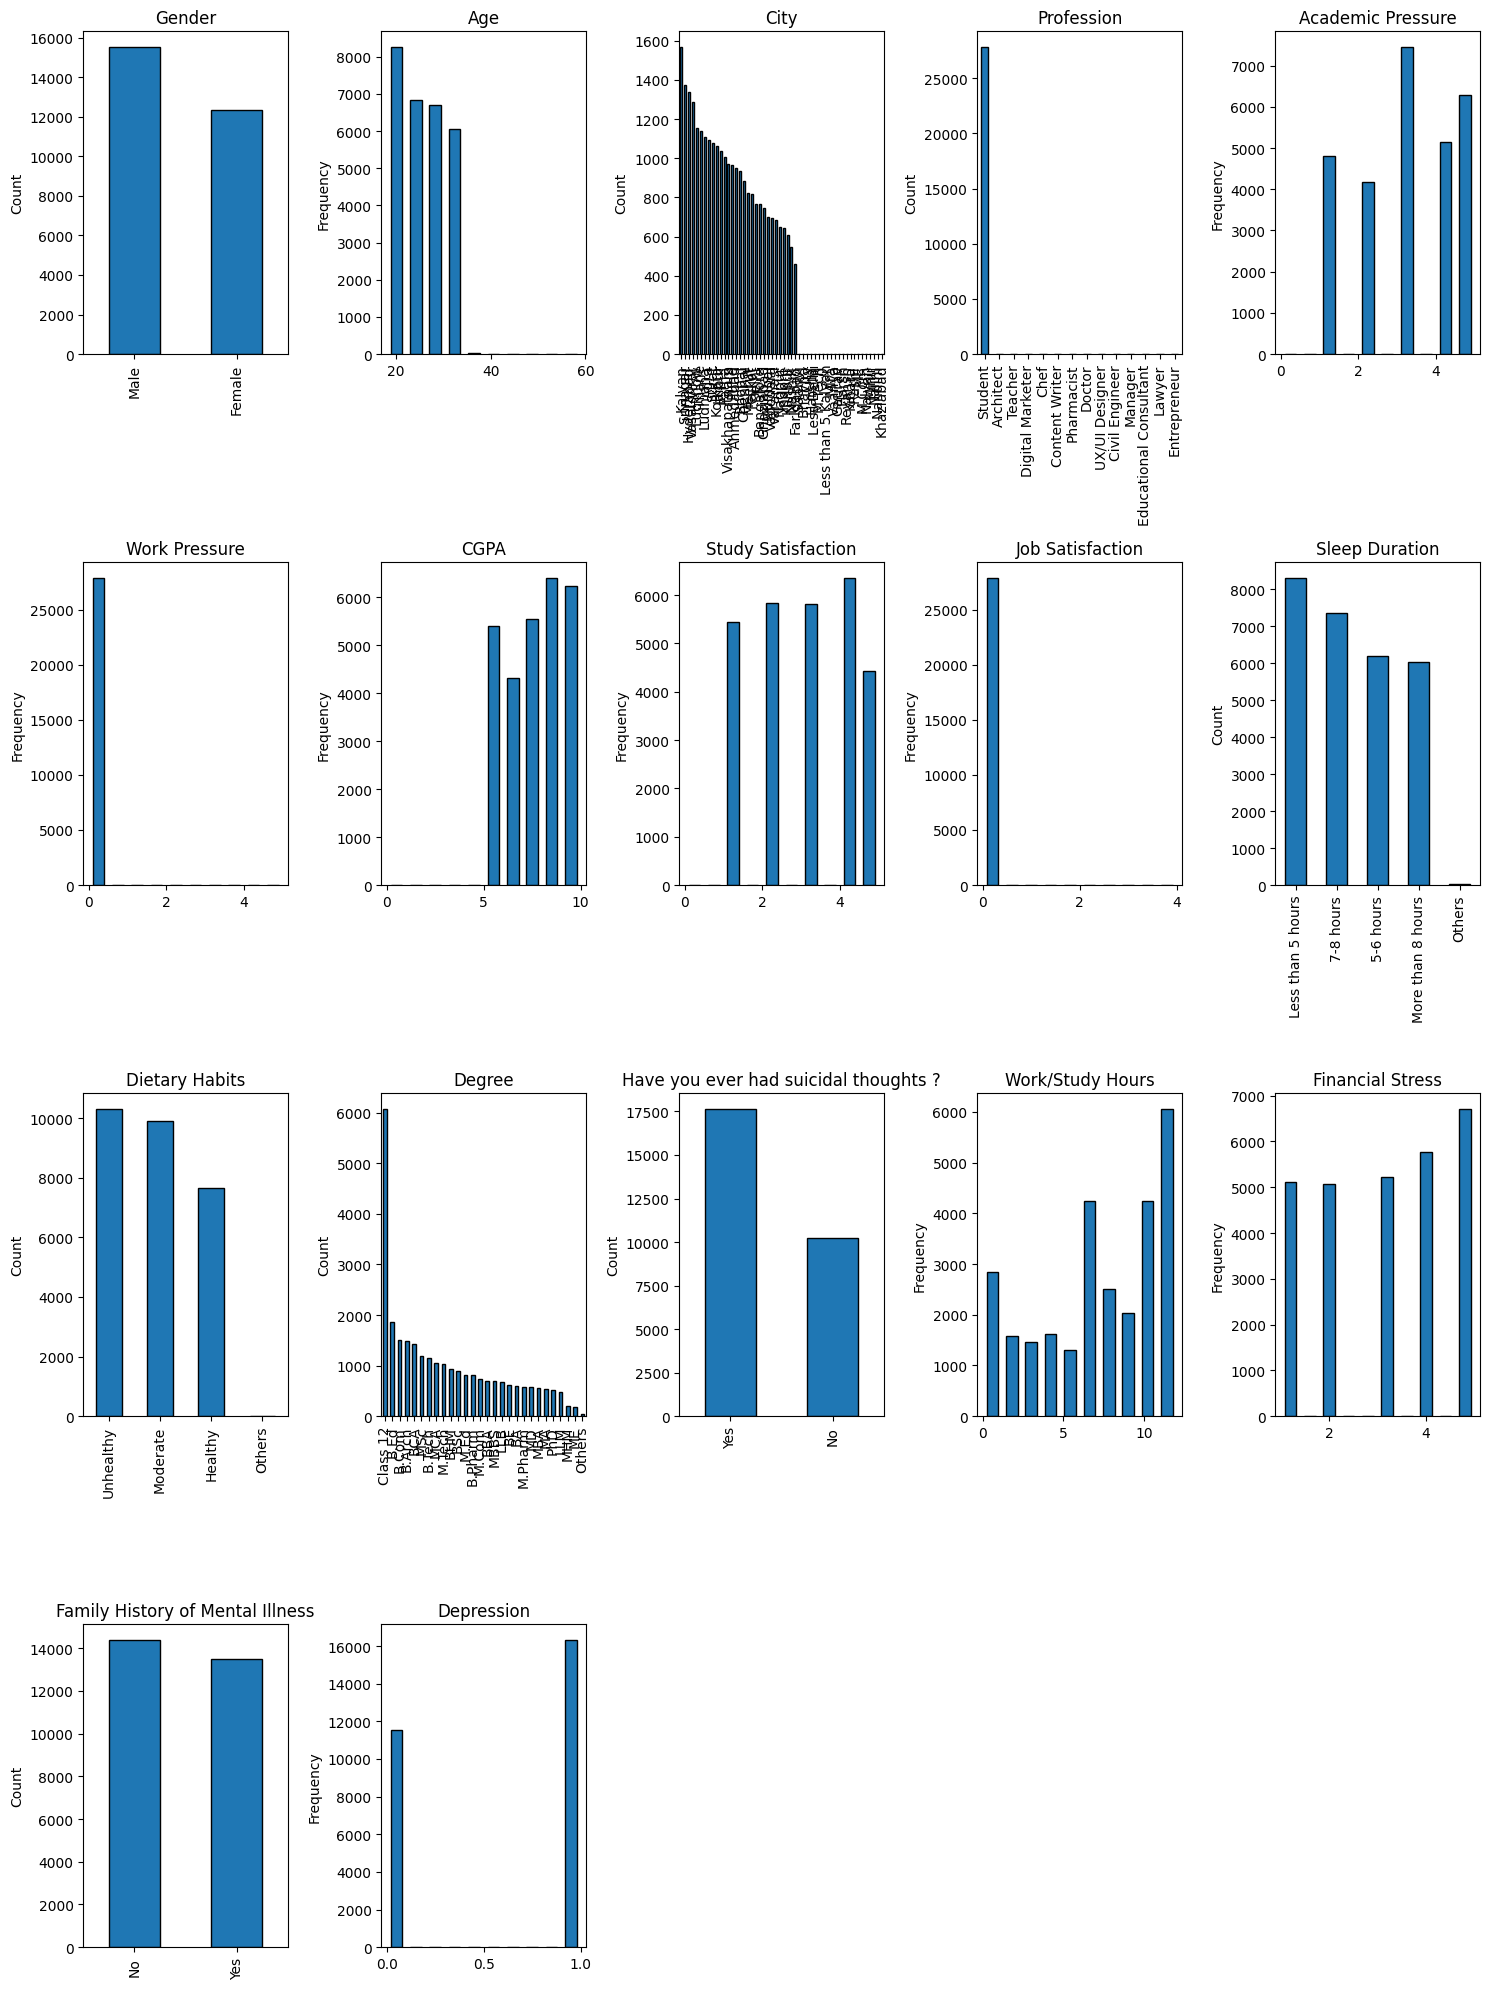

In [87]:
from utils import plot_dataframe_columns
plot_dataframe_columns(df_notna)

In [88]:
tot = df_notna.shape[0]

working_students = df_notna[df_notna["Profession"]!="Student"].index.to_list()
print(f"There are {len(working_students)} working students ({len(working_students)/tot*100:.2f}%)")

pression_students = df_notna[df_notna["Work Pressure"]!=0].index.to_list()
print(f"There are {len(working_students)} work-pressed students ({len(pression_students)/tot*100:.2f}%)")

satisfied_students = df_notna[df_notna["Job Satisfaction"]!=0].index.to_list()
print(f"There are {len(satisfied_students)} work-satisfied students ({len(satisfied_students)/tot*100:.2f}%)")

There are 31 working students (0.11%)
There are 31 work-pressed students (0.01%)
There are 8 work-satisfied students (0.03%)


We can notice an interesting patter about work. It seems like indian students are not likely to be also workers. In fact we can notice that in "Profession" is almpst completely filled by students and also "Job Satisfcation" and "Work Pressure" shows 0 as predominant value as almost no one works.

We tried to figure out an explanation for this phenomenon but we only faced online discussions about it.

Given that, we decided to delete the 'work' variable from our domain so we'll drop "Job Satisfaction", "Work Pressure", "Profession" and all the students that also works.

In [89]:
df_cleaned = df_notna.drop(columns=["Profession", "Work Pressure", "Job Satisfaction"])
df_cleaned.drop(index=working_students, inplace=True)
df_cleaned.rename(columns={"Work/Study Hours" : "Study Hours"}, inplace=True)   # for coherence

print(f"New shape: {df_cleaned.shape}")

New shape: (27867, 14)


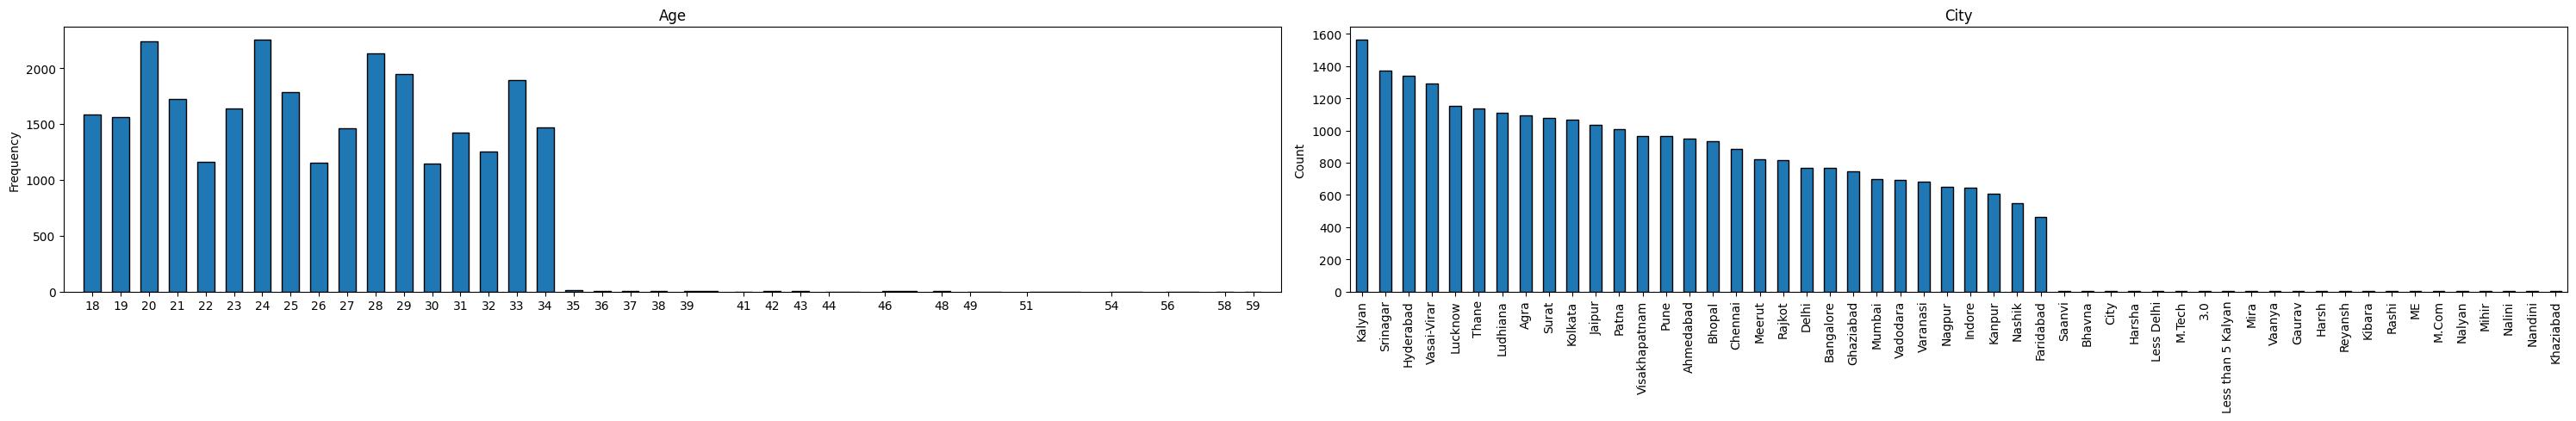

In [90]:
plot_dataframe_columns(df_cleaned[["Age", "City"]], figsize_base=(30, 5), bins=60, show_all_xticks=True)

In [91]:
threshold = 1 # % threshold over all the samples
city_counts = df_cleaned['City'].value_counts()
unpopular_cities = city_counts[city_counts < threshold/100*df_cleaned.shape[0]].index
students_in_unpopular_cities = df_cleaned[df_cleaned['City'].isin(unpopular_cities)].shape[0]
print(f"There are {students_in_unpopular_cities} students (the {100*students_in_unpopular_cities/df_cleaned.shape[0]:.2f}%) in unpopular cities (which are {len(unpopular_cities)})")

# 34 observed by plot
over_34_students = df_cleaned[df_cleaned['Age'] > 34].shape[0]
print(f"There are {over_34_students} students (the {100*over_34_students/df_cleaned.shape[0]:.2f}%) over 34 y/o")

There are 26 students (the 0.09%) in unpopular cities (which are 22)
There are 49 students (the 0.18%) over 34 y/o


We can notice that "Age" and "City" has many values that are not very frequent and we will cope with them differently:
- **Age**: we will keep the values but will have to consider the unbalancement by slightly modifying the classical binning of age in order to inspect the attribute more effectively.
- **City**: the 22 unpoular cities were difficult to find online and so, considering their small amount of samples, we'll delete them.

New shape: (27841, 14)


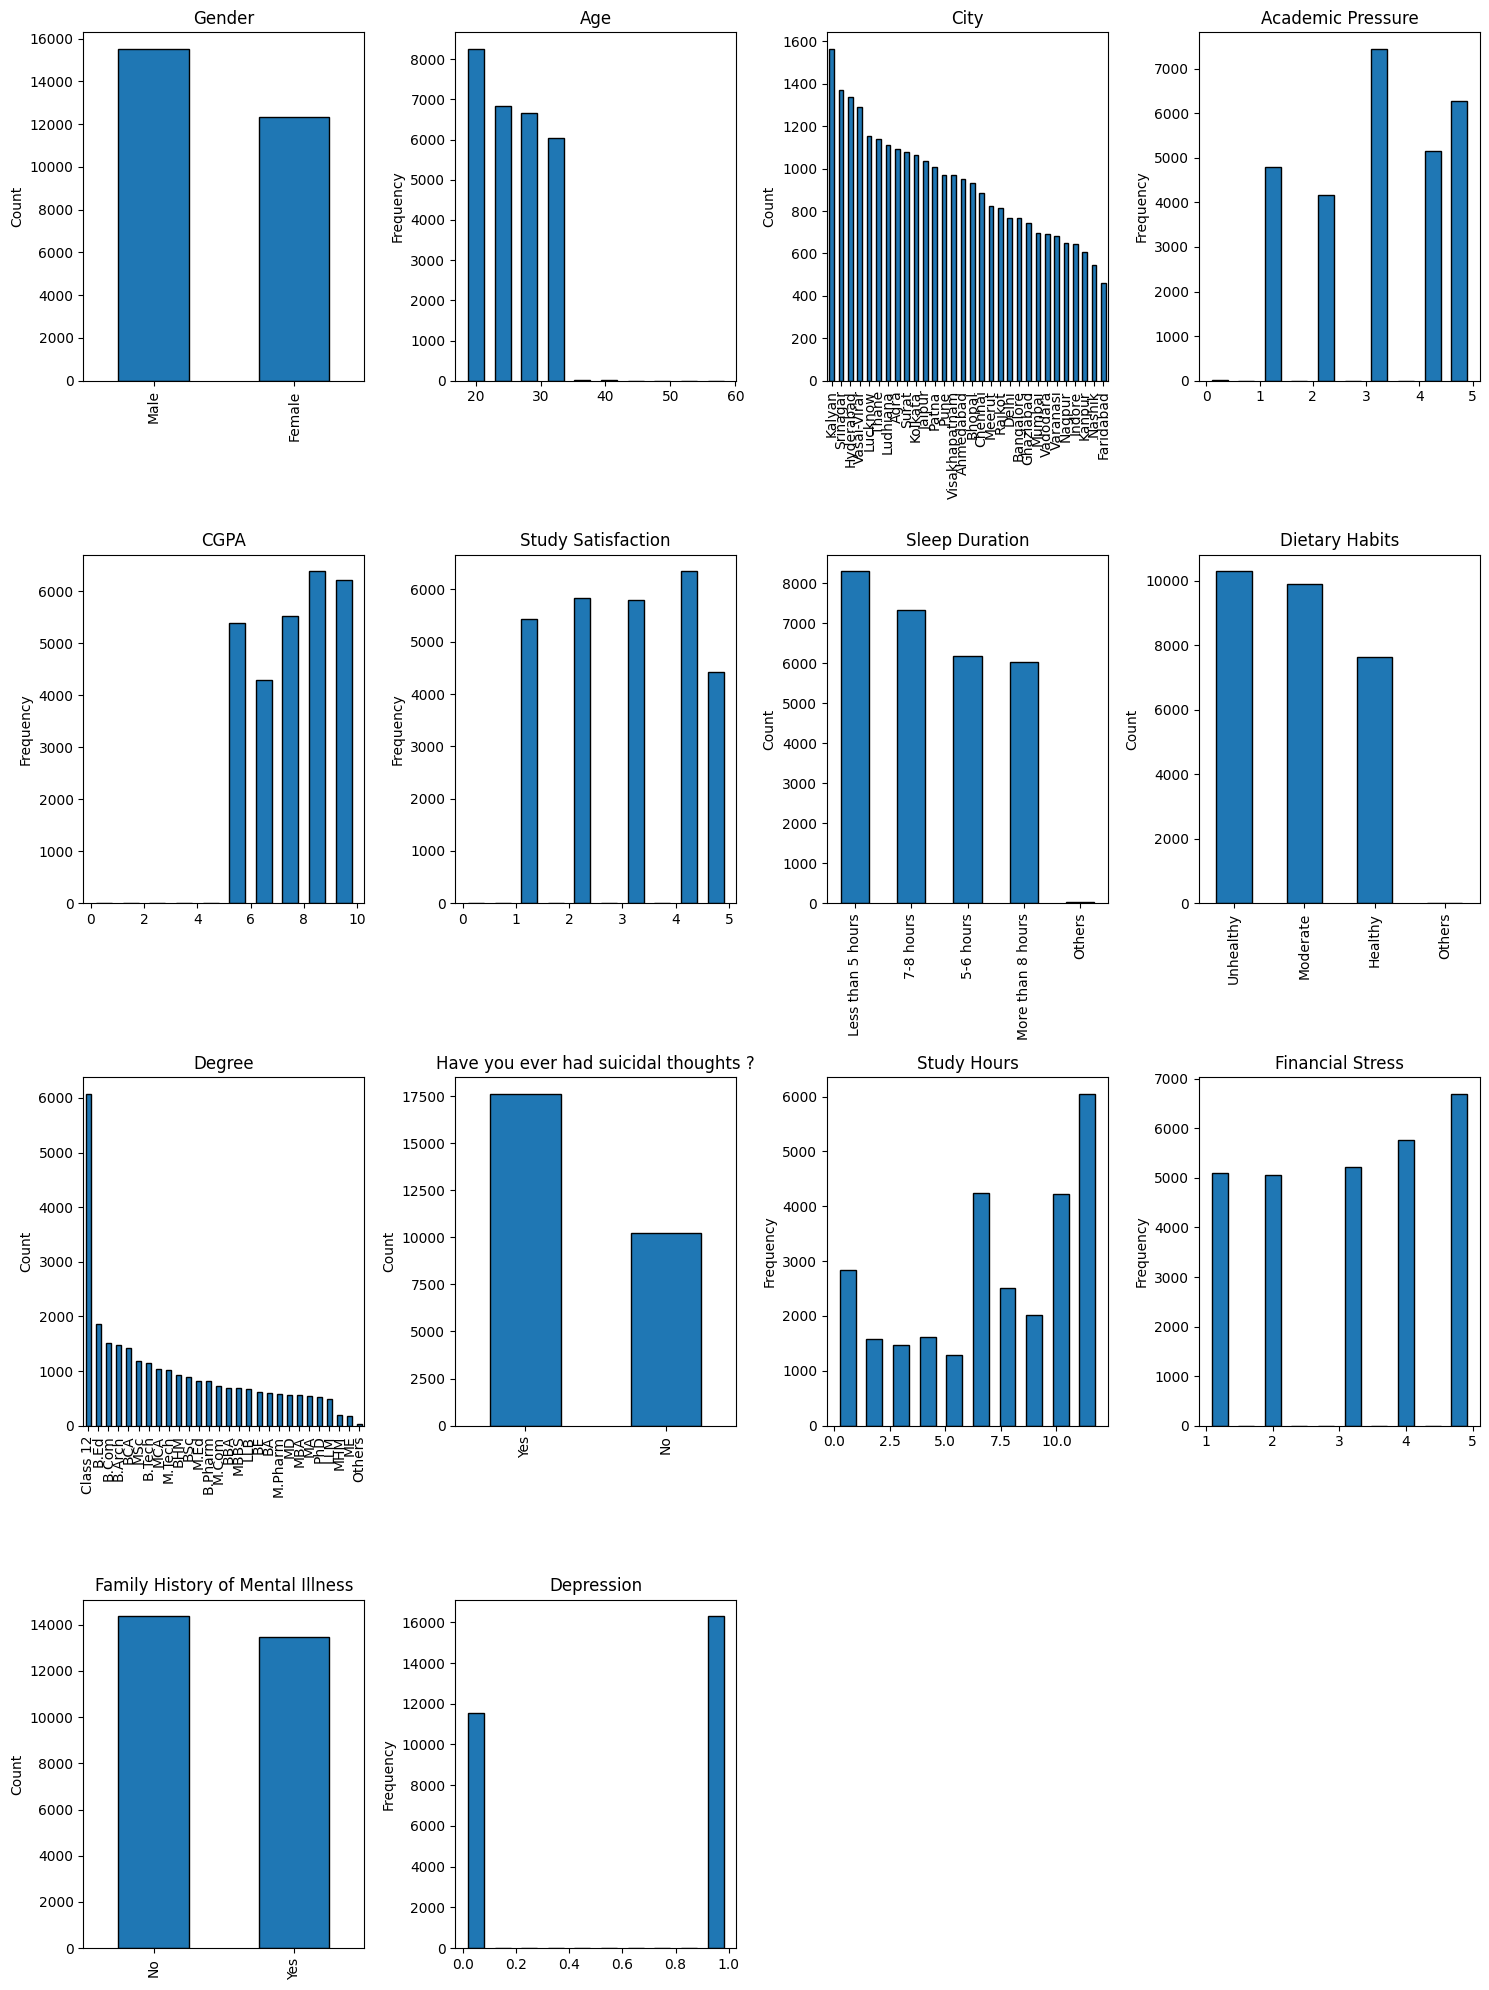

In [92]:
unpop_city_idxs = df_cleaned[df_cleaned['City'].isin(unpopular_cities)].index.to_list()
df_cleaned.drop(index=unpop_city_idxs, inplace=True)
df_cleaned.reset_index(drop=True, inplace=True)     

print(f"New shape: {df_cleaned.shape}")

plot_dataframe_columns(df_cleaned)

## Binning and encoding

1. [Gender](#gender)
2. [Age](#age)
3. [City](#city)
4. [Sleep Duration](#sleep-duration)
5. [Dietary Habits](#dietary-habits)
6. [Degree](#degree)
7. [Suicidial Thougths](#suicidial-thougths)
8. [Study Hours](#study-hours)
9. [Mental Ilness](#mental-illness)
10. [Financial Stress](#financial-stress)

In [93]:
df_final = pd.DataFrame()
label_mappings = {}         # in order to keep track of encodings 

### Gender

In [94]:
from sklearn.preprocessing import LabelEncoder

label = "Gender"

encoder = LabelEncoder()
df_final[label] = encoder.fit_transform(df_cleaned[label])

label_mappings[label] = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
label_mappings[label]

{'Female': 0, 'Male': 1}

### Age

We followed the [Provisional Guidelines on Standard International Age Classification](https://unstats.un.org/unsd/publication/seriesm/seriesm_74e.pdf), we chose the most detailed scale in order to better follow the distribution of "Age" values with mostly young individuals.

In [95]:
label = "Age"

min = df_cleaned[label].min()
max = df_cleaned[label].max()
print(f"The range is [{min},{max}]")

bins = [min-1, 24, 29, 34, max]  
bin_label = list(range(len(bins) - 1))  

df_final[label] = pd.cut(
    df_cleaned[label], 
    bins=bins, 
    labels=bin_label
).reset_index(drop=True).astype(int)

label_mappings[label] = {f"{int(bins[l])+1}-{int(bins[l+1])}": l for l in bin_label}
label_mappings[label]

The range is [18.0,59.0]


{'18-24': 0, '25-29': 1, '30-34': 2, '35-59': 3}

### City

Here we tried to obtain more information than the one we were given, since the city per se is a bit meaningless. Moreover is difficult to obtain data on the wellness of the individual starting from the city's economy as India is one of the most "unequal" country (as could be seen in the [World Inequality Report](https://wir2022.wid.world/www-site/uploads/2023/03/D_FINAL_WIL_RIM_RAPPORT_2303.pdf)). So we tried to merge the geographical information with an observation about [regional division and dsparity](https://www.researchgate.net/profile/Sivakumar-Iyyanar/publication/342590854_REGIONAL_DISPARITIES_AND_INDIAN_STATES_A_MACRO_LEVEL_STUDY/links/5efc5cee45851550508109f4/REGIONAL-DISPARITIES-AND-INDIAN-STATES-A-MACRO-LEVEL-STUDY.pdf) in order to group cities in macro areas and maybe infer somenthing about their level of social difficulty.

In [96]:
label='Regions'

# label create a new attribute with regions
label_city_regions={
    'Agra':'Central',
    'Ahmedabad':'Western',
    'Bangalore': 'Southern',
    'Bhopal':'Central',
    'Chennai':'Southern',
    'Delhi':'Northern',
    'Faridabad':'Northern',
    'Ghaziabad':'Central',
    'Hyderabad':'Southern',
    'Indore':'Central',
    'Jaipur':'Northern',
    'Kalyan':'Western',
    'Kanpur':'Central',
    'Kolkata':'Eastern',
    'Lucknow':'Central',
    'Ludhiana':'Northern',
    'Meerut':'Central',
    'Mumbai':'Western',
    'Nagpur':'Western',
    'Nashik':'Western',
    'Patna':'Eastern',
    'Pune':'Western',
    'Rajkot':'Western',
    'Srinagar':'Northern',
    'Surat':'Western',
    'Thane':'Western',
    'Vadodara':'Western',
    'Varanasi':'Central',
    'Vasai-Virar':'Western',
    'Visakhapatnam':'Southern',
}

df_cleaned[label]=df_cleaned['City'].map(label_city_regions)

regions=df_cleaned[label].unique().tolist()
label_mappings[label] = {regions[l]: l for l in range(len(regions))}

df_final[label]=df_cleaned[label].map(label_mappings[label]).reset_index(drop=True)
label_mappings[label]

{'Southern': 0, 'Northern': 1, 'Central': 2, 'Western': 3, 'Eastern': 4}

### CGPA

Then we followed the [guidelines of an indian university](https://www.suniv.ac.in/upload/UGC%20Guidelines.pdf) in order to decide the dimension of CGPA bins.

In [97]:
label = "CGPA"

min = df_cleaned[label].min()
max = df_cleaned[label].max()
print(f"The range is [{min},{max}]")

bins = [min-1, 3.9, 4.9, 5.9, 6.9, 7.9, 8.9, max]  
bin_label = list(range(len(bins) - 1))  

df_final[label] = pd.cut(
    df_cleaned[label], 
    bins=bins, 
    labels=bin_label
).reset_index(drop=True).astype(int)

label_mappings[label] = {f"{int(bins[l])+1}-{bins[l+1]}": l for l in bin_label}
label_mappings[label]

The range is [0.0,10.0]


{'0-3.9': 0,
 '4-4.9': 1,
 '5-5.9': 2,
 '6-6.9': 3,
 '7-7.9': 4,
 '8-8.9': 5,
 '9-10.0': 6}

### Sleep Duration

In [98]:
label = "Sleep Duration"

label_mappings[label] = {
    'Less than 5 hours': 0,
    '5-6 hours': 1,
    '7-8 hours': 2,
    'More than 8 hours': 3,
    'Others': 4
}

df_final[label] = df_cleaned[label].map(label_mappings[label]).reset_index(drop=True)
label_mappings[label]

{'Less than 5 hours': 0,
 '5-6 hours': 1,
 '7-8 hours': 2,
 'More than 8 hours': 3,
 'Others': 4}

### Dietary Habits

In [99]:
label = "Dietary Habits"

label_mappings[label] = {
    'Unhealthy' : 0, 
    'Moderate' : 1, 
    'Healthy' : 2, 
    'Others' : 3
}

df_final[label] = df_cleaned[label].map(label_mappings[label]).reset_index(drop=True)
label_mappings[label]

{'Unhealthy': 0, 'Moderate': 1, 'Healthy': 2, 'Others': 3}

### Degree

Similarly to the "City" case, also for the Degree we think that the single value is not that much important so we tried 2 different groupings.

The first one is by the level of education (high school, barchelor, master, doctorate).

The second one is by the macro-categoy of the degree (scientific, humanistic, ...)

In [100]:
from utils import decode_degree

# Grouping the degrees by the level of education
def get_degree_group(degree):
    degree_groups = {
        "High School Completion": {"Class 12"},
        "Undergraduate Degrees": {
            "B.Pharm", "BSc", "BA", "BCA", "B.Ed", "LLB", "BE", "BHM",
            "B.Com", "B.Arch", "B.Tech", "BBA"
        },
        "Postgraduate Degrees": {
            "M.Tech", "M.Ed", "MSc", "M.Pharm", "MCA", "MA", "MBA", "M.Com",
            "LLM", "ME", "MHM"
        },
        "Doctorate & Medical Degrees": {"PhD", "MD", "MBBS"},
        "Others": {"Others"}
    }
    
    for group, degrees in degree_groups.items():
        if degree in degrees:
            return group
    
    return "Unknown Group"

# Grouping the degrees by educational macro-categories
def get_degree_category(degree):
    degree_categories = {
        "Scientific & Technical": {
            "BSc", "MSc", "B.Tech", "M.Tech", "BE", "ME", "BCA", "MCA", 
            "B.Pharm", "M.Pharm", "B.Arch", "MBBS", "MD"
        },
        "Humanistic & Social Sciences": {
            "BA", "MA", "B.Ed", "M.Ed", "LLB", "LLM", "B.Com", "M.Com", "BBA", "MBA"
        },
        "Medical & Life Sciences": {
            "MBBS", "MD", "B.Pharm", "M.Pharm"
        },
        "Legal & Political Sciences": {
            "LLB", "LLM"
        },
        "Business & Economics": {
            "B.Com", "M.Com", "BBA", "MBA"
        },
        "Hospitality & Tourism": {
            "BHM", "MHM"
        },
        "Doctorate & Research": {
            "PhD"
        },
        "Others": {"Class 12", "Others"}
    }
    
    for category, degrees in degree_categories.items():
        if degree in degrees:
            return category
    
    return "Unknown Category"

In [101]:
label = "Education Level"

label_mappings[label] = {
    'High School Completion': 0,
    'Undergraduate Degrees': 1,
    'Postgraduate Degrees': 2,
    'Doctorate & Medical Degrees': 3,
    'Others': 4
}

df_final[label] = df_cleaned["Degree"] \
                    .map(get_degree_group) \
                    .map(label_mappings[label]).reset_index(drop=True)
label_mappings[label]

{'High School Completion': 0,
 'Undergraduate Degrees': 1,
 'Postgraduate Degrees': 2,
 'Doctorate & Medical Degrees': 3,
 'Others': 4}

In [102]:
label = "Education Category"

label_mappings[label] = {
    'Hospitality & Tourism': 0,
    'Humanistic & Social Sciences': 1,
    'Scientific & Technical': 2,
    'Doctorate & Research': 3,
    'Others': 4
}

df_final[label] = df_cleaned["Degree"] \
                    .map(get_degree_category) \
                    .map(label_mappings[label]).reset_index(drop=True)
label_mappings[label]

{'Hospitality & Tourism': 0,
 'Humanistic & Social Sciences': 1,
 'Scientific & Technical': 2,
 'Doctorate & Research': 3,
 'Others': 4}

### Suicidal Thoughts

In [103]:
label = "Have you ever had suicidal thoughts ?"

encoder = LabelEncoder()
df_final[label] = encoder.fit_transform(df_cleaned[label])

label_mappings[label] = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
label_mappings[label]

{'No': 0, 'Yes': 1}

### Study Hours

In [104]:
label = "Study Hours"

min_val = int(df_cleaned[label].min())
max_val = int(df_cleaned[label].max())
print(f"The range is [{min_val},{max_val}]")

# Each bin after 3h
bins = [*range(min_val, max_val + 1, 3)]  
bins[-1] += 1   # othervise the other is not considered
bin_label = list(range(len(bins) - 1))

df_final[label] = pd.cut(
    df_cleaned[label], 
    bins=bins, 
    labels=bin_label,
    right=False,  #[)
).reset_index(drop=True).astype(int)

label_mappings[label] = {f"{bins[l]}-{bins[l+1]-1}": l for l in bin_label}
label_mappings[label]


The range is [0,12]


{'0-2': 0, '3-5': 1, '6-8': 2, '9-12': 3}

### Mental Illness

In [105]:
label = "Family History of Mental Illness"

encoder = LabelEncoder()
df_final[label] = encoder.fit_transform(df_cleaned[label])

label_mappings[label] = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
label_mappings[label]

{'No': 0, 'Yes': 1}

### Financial Stress

This attribute has a range of values [1,5] and in order to provide a coherent encoding, we scale it in [0,4].

In [106]:
attr = "Financial Stress"

# If-else in otder not to be changed after multiple executions
if (attr not in df_final) or (0 not in df_final[attr].unique()) :  
    df_final[attr] = df_cleaned[attr] - 1

## Final Result

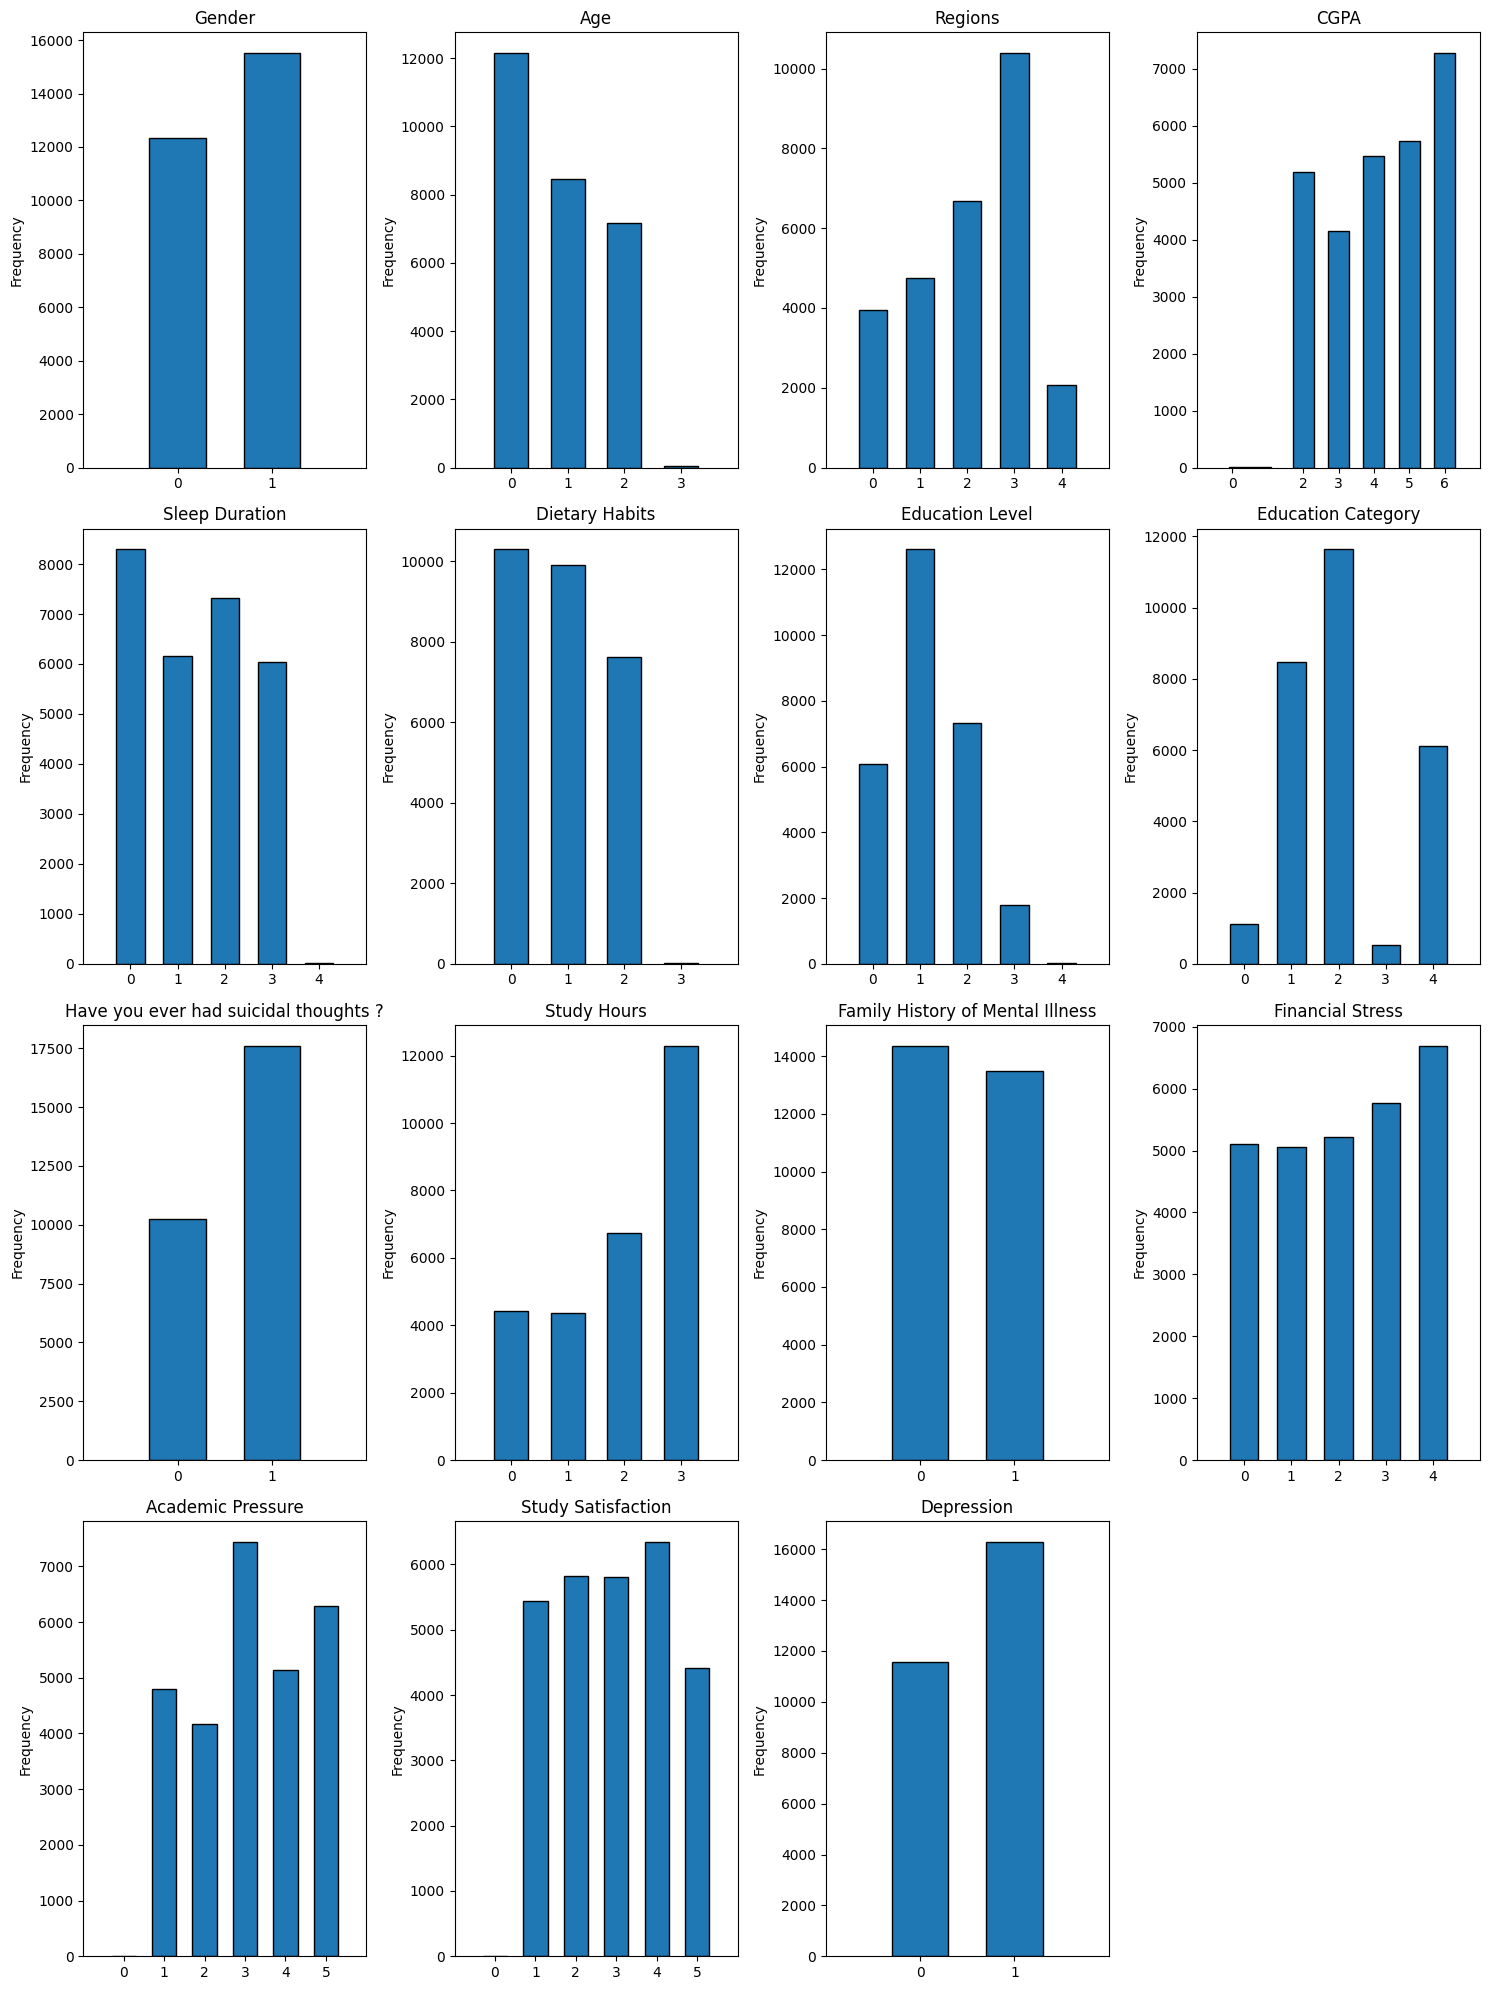

In [107]:
import pickle 
from utils import to_camel_case

# Add the remaining attributes
rem_attrs = ["Academic Pressure", "Study Satisfaction", "Depression"]
for attr in rem_attrs:
    df_final[attr] = df_cleaned[attr].copy().astype(int)
    
# Plot
plot_dataframe_columns(df_final, show_all_xticks=True)

# Convert in BayesianNetwork notation
df_final.columns = [to_camel_case(col) for col in df_final.columns] 
label_mappings = {to_camel_case(col):v for col,v in label_mappings.items()}

# Save the new dataset and its mapping
df_final.to_csv("./datasets/dataset_final.csv", index=False)
with open("./datasets/label_mappings.pkl", 'wb') as f: pickle.dump(label_mappings, f)